In [1]:
import wget
import tarfile
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:
# Download image.tar file
if "images.tar" not in os.listdir() :
    wget.download('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')
    
# Extract images from tar file
current_dir = os.getcwd()
tar_file = os.path.join(current_dir, "images.tar")

with tarfile.open(tar_file, 'r') as tar:
    tar.extractall(current_dir)
    
# Define the transform to convert images to tensors
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Convert images into tensors and assign class labels
full_dataset = datasets.ImageFolder(root = "Images", transform=transform)
full_dataset.classes = [image.split("-")[1] for image in full_dataset.classes]

# Define the split ratio
split_ratio = 0.75

# Split the dataset
train_size = int(split_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create dataloaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=120, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=120, shuffle=False)

In [3]:
resnet50_model = models.resnet50(weights=True)
for param in resnet50_model.parameters():
    param.requires_grad = False                   
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_features, 120)

vgg16_model = models.vgg16(weights=True)
for param in vgg16_model.parameters():
    param.requires_grad = False                     
num_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_features, 120)

vit_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
for param in vit_model.parameters():
    param.requires_grad = False  
vit_model.heads[0] = nn.Linear(768, 120, bias = True)

/home/dlongert/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dlongert/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
loss_function = nn.CrossEntropyLoss()

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [5]:
def train_model(model, num_epochs, optimizer):
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    model = model.to(device)
    model = model.cuda()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            
            output = model(data)
            optimizer.zero_grad()
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

        train_loss = train_loss / total_train
        train_accuracy = correct_train / total_train
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                
                output = model(data)
                loss = loss_function(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                correct_valid += (predicted == target).sum().item()
                total_valid += target.size(0)

        valid_loss = valid_loss / total_valid
        valid_accuracy = correct_valid / total_valid
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_accuracy)

        # Print epoch summary
        print(f'Epoch {epoch + 1} \t Training Accuracy: {train_accuracy*100:.3f}% \t Validation Accuracy: {valid_accuracy*100:.3f}%')
        print(f'\t\t Training Loss: {train_loss:.3f} \t Validation Loss: {valid_loss:.3f}')
        print('-' * 100)

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

In [6]:
optimizer_resnet50 = torch.optim.Adam(params = resnet50_model.parameters(), lr = 0.0001)
train_loss_resnet50, test_loss_resnet50, train_accs_resnet50, test_accs_resnet50 = train_model(resnet50_model, 20, optimizer_resnet50)

Epoch 1 	 Training Accuracy: 32.368% 	 Validation Accuracy: 60.972%
		 Training Loss: 4.047 	 Validation Loss: 3.296
----------------------------------------------------------------------------------------------------
Epoch 2 	 Training Accuracy: 68.818% 	 Validation Accuracy: 74.363%
		 Training Loss: 2.743 	 Validation Loss: 2.264
----------------------------------------------------------------------------------------------------
Epoch 3 	 Training Accuracy: 77.570% 	 Validation Accuracy: 77.940%
		 Training Loss: 1.926 	 Validation Loss: 1.666
----------------------------------------------------------------------------------------------------
Epoch 4 	 Training Accuracy: 80.862% 	 Validation Accuracy: 80.428%
		 Training Loss: 1.460 	 Validation Loss: 1.331
----------------------------------------------------------------------------------------------------
Epoch 5 	 Training Accuracy: 82.410% 	 Validation Accuracy: 81.380%
		 Training Loss: 1.188 	 Validation Loss: 1.126
-----------

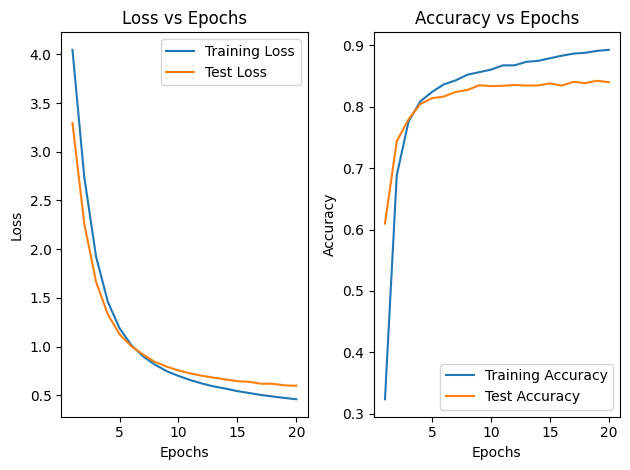

In [7]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 20 + 1), train_loss_resnet50, label='Training Loss')
plt.plot(range(1, 20 + 1), test_loss_resnet50, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 20 + 1), train_accs_resnet50, label='Training Accuracy')
plt.plot(range(1, 20 + 1), test_accs_resnet50, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
optimizer_vgg16 = torch.optim.Adam(params = vgg16_model.parameters(), lr = 0.0001)
train_loss_vgg16, test_loss_vgg16, train_accs_vgg16, test_accs_vgg16 = train_model(vgg16_model, 20, optimizer_vgg16)

Epoch 1 	 Training Accuracy: 21.140% 	 Validation Accuracy: 48.980%
		 Training Loss: 3.676 	 Validation Loss: 2.806
----------------------------------------------------------------------------------------------------
Epoch 2 	 Training Accuracy: 46.090% 	 Validation Accuracy: 56.443%
		 Training Loss: 2.425 	 Validation Loss: 2.158
----------------------------------------------------------------------------------------------------
Epoch 3 	 Training Accuracy: 54.214% 	 Validation Accuracy: 58.484%
		 Training Loss: 1.959 	 Validation Loss: 1.870
----------------------------------------------------------------------------------------------------
Epoch 4 	 Training Accuracy: 57.279% 	 Validation Accuracy: 59.650%
		 Training Loss: 1.736 	 Validation Loss: 1.710
----------------------------------------------------------------------------------------------------
Epoch 5 	 Training Accuracy: 59.417% 	 Validation Accuracy: 61.341%
		 Training Loss: 1.600 	 Validation Loss: 1.602
-----------

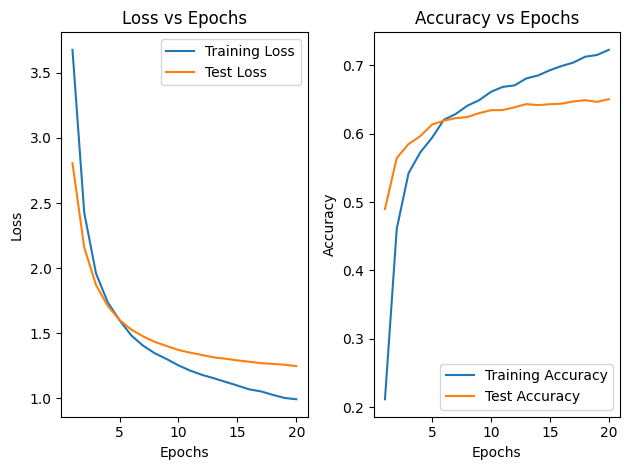

In [9]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 20 + 1), train_loss_vgg16, label='Training Loss')
plt.plot(range(1, 20 + 1), test_loss_vgg16, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 20 + 1), train_accs_vgg16, label='Training Accuracy')
plt.plot(range(1, 20 + 1), test_accs_vgg16, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
optimizer_vit = torch.optim.Adam(params = vit_model.parameters(), lr = 0.0001)
train_loss_vit, test_loss_vit, train_accs_vit, test_accs_vit = train_model(vit_model, 20, optimizer_vit)

Epoch 1 	 Training Accuracy: 35.407% 	 Validation Accuracy: 74.947%
		 Training Loss: 4.172 	 Validation Loss: 3.522
----------------------------------------------------------------------------------------------------
Epoch 2 	 Training Accuracy: 81.503% 	 Validation Accuracy: 85.928%
		 Training Loss: 2.945 	 Validation Loss: 2.404
----------------------------------------------------------------------------------------------------
Epoch 3 	 Training Accuracy: 86.693% 	 Validation Accuracy: 88.222%
		 Training Loss: 1.958 	 Validation Loss: 1.582
----------------------------------------------------------------------------------------------------
Epoch 4 	 Training Accuracy: 88.390% 	 Validation Accuracy: 89.640%
		 Training Loss: 1.299 	 Validation Loss: 1.085
----------------------------------------------------------------------------------------------------
Epoch 5 	 Training Accuracy: 89.602% 	 Validation Accuracy: 89.951%
		 Training Loss: 0.923 	 Validation Loss: 0.811
-----------

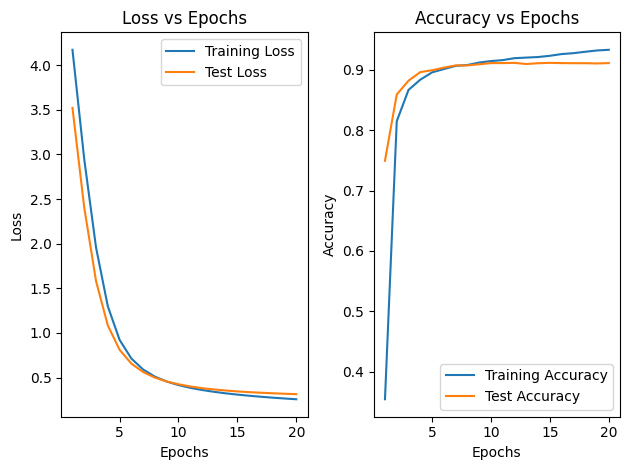

In [11]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 20 + 1), train_loss_vit, label='Training Loss')
plt.plot(range(1, 20 + 1), test_loss_vit, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 20 + 1), train_accs_vit, label='Training Accuracy')
plt.plot(range(1, 20 + 1), test_accs_vit, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()